# Block Based Motion Estimation

In [1]:
import numpy as np
import frame
import YCoCg as YUV
import motion
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import LP
import cv2 as cv

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5


In [2]:
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_frame(frame, prefix=None):
    #frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(frame)
    
def show_vectors(flow, dpi=150):
    #plt.figure.set_dpi(200)
    plt.figure(dpi=dpi)
    plt.quiver(flow[..., 0], flow[..., 1])
    plt.show()

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/moving_circles/", 0))[...,0]
P = YUV.from_RGB(frame.read("../sequences/moving_circles/", 1))[...,0]

In [ ]:
flow = motion.estimate(P, R)

In [ ]:
show_vectors(flow[::2, ::2])

In [ ]:
flow.min()

In [ ]:
for i in range(64):
    for j in range(64):
        print((np.rint(flow)[i,j][1]), end=' ')
    print()

In [ ]:
show_frame(flow[...,0])

In [ ]:
R = frame.read("../sequences/moving_circles/", 0)
P = frame.read("../sequences/moving_circles/", 1)
prediction = motion.make_prediction(R, flow)
show_frame(prediction)
show_frame(P)

In [ ]:
show_frame(P-prediction)

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/moving_circles/", 0))[...,0]
P = YUV.from_RGB(frame.read("../sequences/moving_circles/", 1))[...,0]

In [ ]:
#      5       3       8
#      1       0       2
#      7       4       6
# (-1,-1) (-1, 0) (-1, 1)
# ( 0,-1) ( 0, 0) ( 0, 1)
# ( 1,-1) ( 1, 0) ( 1, 1)
#spiral  = np.array([(-1,-1), (-1, 1), ( 1,-1), ( 1, 1), (-1, 0), ( 1, 0), ( 0,-1), ( 0, 1), ( 0, 0)])
spiral  = np.array([( 0, 0), (-1,-1), (-1, 1), ( 1,-1), ( 1, 1), (-1, 0), ( 1, 0), ( 0,-1), ( 0, 1)])
spiral  = np.array([( 0, 0), ( 0,-1), ( 0, 1), (-1, 0), ( 1, 0), (-1,-1), ( 1, 1), ( 1,-1), (-1, 1)])

# (0,0) (0,1) (0,2)
# (1,0) (1,1) (1,2)
# (2,0) (2,1) (2,2)
spiral_ = np.array([( 1, 1), ( 0, 0), ( 0, 2), ( 2, 0), ( 2, 2), ( 0, 1), ( 2, 1), ( 1, 0), ( 1, 2)])
spiral_ = np.array([( 1, 1), ( 1, 0), ( 1, 2), ( 0, 1), ( 2, 1), ( 0, 0), ( 2, 2), ( 2, 0), ( 0, 2)])

In [ ]:
# (x, y)
#      5       3       8
#      1       0       2
#      7       4       6
# (-1,-1) ( 0,-1) ( 1,-1)
# (-1, 0) ( 0, 0) ( 1, 0)
# (-1, 1) ( 0, 1) ( 1, 1)
spiral  = np.array([( 0, 0), (-1, 0), ( 1, 0), ( 0,-1), ( 0, 1), (-1,-1), ( 1, 1), (-1, 1), ( 1,-1)], dtype=np.int16)
#                        0        1        2        3        4        5        6        7        8

# (0,0) (1,0) (2,0)
# (0,1) (1,1) (2,1)
# (0,2) (1,2) (2,2)
spiral_ = np.array([( 1, 1), ( 0, 1), ( 2, 1), ( 1, 0), ( 1, 2), ( 0, 0), ( 2, 2), ( 0, 2), ( 2, 0)], dtype=np.int16)

In [ ]:
print(spiral.dtype)

In [ ]:
extended_R = np.zeros((R.shape[0]+2, R.shape[1]+2))
extended_R[1:R.shape[0]+1, 1:R.shape[1]+1] = R

In [ ]:
#extended_R = np.pad(R, (1, 1), 'edge') # Ojo, no funciona

In [ ]:
show_frame(extended_R)

In [ ]:
D = np.zeros((P.shape[0], P.shape[1], 9), dtype=np.float32)

In [ ]:
for i in range(9):
    diff = extended_R[spiral_[i][1]:R.shape[0]+spiral_[i][1], spiral_[i][0]:R.shape[1]+spiral_[i][0]] - P
    D[:,:,i] = diff*diff

In [ ]:
print(D[0,0,0], D[0,0,1], D[0,0,2], D[0,0,3])

In [ ]:
DD = np.empty_like(D).astype(np.float32)
DD[...] = D
print(D[0,0,1])
show_frame(D[...,0])
kernel = np.ones((15,15),np.float32)/(15*15)
D = cv.filter2D(DD,-1,kernel)
#show_frame(D[...,0]+D[...,1])
show_frame(np.rint(D[...,0]))


In [ ]:
flow_indexes = np.argmin(np.rint(D), axis=2)
for i in range(64):
    for j in range(64):
        print(flow_indexes[i,j], end='')
    print()

In [ ]:
show_frame(flow_indexes)

In [ ]:
print(D[0,0,0], D[0,0,1], D[0,0,2], D[0,0,3])

In [ ]:
flow = spiral[flow_indexes]

In [ ]:
show_frame(D[:,:,1] - D[:,:,8])

In [ ]:
R = frame.read("../sequences/moving_circles/", 0)

In [ ]:
show_frame(R)

In [ ]:
prediction = motion.make_prediction(R, flow.astype(np.float32))

In [ ]:
show_frame(prediction)

In [ ]:
P = frame.read("../sequences/moving_circles/", 1)
show_frame(P)

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/moving_circles/", 0))
P = YUV.from_RGB(frame.read("../sequences/moving_circles/", 2))

In [ ]:
def spiral_estimate(P, R, window_side=15):
    print("window_side =", window_side)
    extended_R = np.zeros((R.shape[0]+2, R.shape[1]+2))
    extended_R[1:R.shape[0]+1, 1:R.shape[1]+1] = R
    print("extended_R.shape", extended_R.shape)
    #extended_R = np.pad(R, (1, 1), 'edge')
    #print("extended_R.shape", extended_R.shape)
    D = np.zeros((P.shape[0], P.shape[1], 9), dtype=np.float32)
    for i in range(9):
        diff = extended_R[spiral_[i][1] : R.shape[0] + spiral_[i][1],
                          spiral_[i][0] : R.shape[1] + spiral_[i][0]] - P
        D[:,:,i] = diff*diff
    # Tenemos la distancia L2, pixel-wise, para cada posible desplazamiento de ambas matrices, R y P.
    # Ahora se trata de encontrar una nueva matriz de distancias donde se tenga en cuenta las distancias adyacentes.
    DD = np.empty_like(D).astype(np.float32)
    DD[...] = D
    kernel = np.ones((window_side,window_side),np.float32)/(window_side*window_side)
    D = cv.filter2D(DD, -1, kernel)
    #show_frame(D[...,0]+D[...,1])
    #show_frame(D[...,0])
    #for y in range(D.shape[0]):
    #    for x in range(D.shape[1]):
    #        print(D[y,x], end=' ')
    #    print()
    #print(80*"=")
    flow_indexes = np.argmin(np.rint(D), axis=2)
    for i in range(flow_indexes.shape[0]):
        for j in range(flow_indexes.shape[1]):
            print(flow_indexes[i,j], end='')
        print()
    print(80*"=")
    flow = spiral[flow_indexes]
    return flow

In [ ]:
flow = spiral_estimate(P[...,0], R[...,0])

In [ ]:
# Funciona para log2_search_area = 0 y 1 (search_area 1 y 2)
def estimate(P, R, log2_search_area, n_levels):
    if log2_search_area > 0:
        P_pyramid = LP.analyze(P, log2_search_area)
        R_pyramid = LP.analyze(R, log2_search_area)
    else:
        P_pyramid = [P]
        R_pyramid = [R]
    #total_flow = np.zeros(((R_pyramid[0].shape[0]+1)//2, (R_pyramid[0].shape[1]+1)//2, 2), dtype=np.int16)
    total_flow = np.zeros((R_pyramid[0].shape[0], R_pyramid[0].shape[1], 2), dtype=np.int16)
    for l in range(n_levels):
        _R_pyramid = motion.make_prediction(R_pyramid[l], total_flow.astype(np.float32))
        flow = spiral_estimate(P_pyramid[l], _R_pyramid)
        total_flow *= 2
        total_flow += flow
        total_flow = total_flow.astype(np.int16)
        #for y in range(total_flow.shape[0]):
        #    for x in range(total_flow.shape[1]):
        #        print(total_flow[y,x], end=' ')
        #    print()
        #print(80*"=")
        #show_frame(R_pyramid[l+1])
        R_pyramid[l+1] = LP.synthesize_step(R_pyramid[l], R_pyramid[l+1])
        P_pyramid[l+1] = LP.synthesize_step(P_pyramid[l], P_pyramid[l+1])
        total_flow = LP.synthesize_step(total_flow.astype(np.float32), np.zeros(total_flow.shape)).astype(np.int16)
    _R = motion.make_prediction(R, total_flow.astype(np.float32))
    flow = spiral_estimate(P, _R)
    if log2_search_area > 0:
        #total_flow = LP.synthesize_step(total_flow.astype(np.float32), np.zeros(total_flow.shape)).astype(np.int16)
        #total_flow *= 2
        total_flow += flow
        total_flow = total_flow.astype(np.int16)
    else:
        return flow
    return total_flow

In [ ]:
flow = estimate(P[...,0], R[...,0], 0, 0)

In [ ]:
def local_estimate(P, R):
    flow = np.zeros((R.shape[0], R.shape[1], 2), dtype=np.int16)
    flow = spiral_estimate(P, R)
    return flow

In [ ]:
local_estimate(P[...,0], R[...,0])

In [ ]:
def spiral_estimate2(initial_flow, P, R, window_side=15):
    print("window_side =", window_side)
    print("inital_flow.dtype", initial_flow.dtype)
    print("R.shape", R.shape)
    print("initial_flow.shape", initial_flow.shape)
    extended_R = np.zeros((R.shape[0]+2, R.shape[1]+2))
    extended_R[1:R.shape[0]+1, 1:R.shape[1]+1] = motion.make_prediction(R, initial_flow)[:R.shape[0], :R.shape[1]]
    show_frame(R, "R")
    show_frame(extended_R[1:R.shape[0]+1, 1:R.shape[1]+1], "extended_R")
    show_frame(P, "P")
    D = np.zeros((P.shape[0], P.shape[1], 9), dtype=np.float32)
    for i in range(9):
        diff = extended_R[spiral_[i][1] : R.shape[0] + spiral_[i][1],
                          spiral_[i][0] : R.shape[1] + spiral_[i][0]] - P
        #print(diff)
        D[:,:,i] = abs(diff)#diff*diff
    # Tenemos la distancia L2, pixel-wise, para cada posible desplazamiento de ambas matrices, R y P.
    # Ahora se trata de encontrar una nueva matriz de distancias donde se tenga en cuenta las distancias adyacentes.
    DD = np.empty_like(D).astype(np.float32)
    DD[...] = D
    #kernel = np.ones((window_side,window_side),np.float32)/(window_side*window_side)
    #D = cv.filter2D(DD, -1, kernel).astype(np.int)
    D = cv.GaussianBlur(DD, (window_side, window_side), 0).astype(np.int)
    #show_frame(D[...,0]+D[...,1])
    #show_frame(D[...,0])
    #for y in range(D.shape[0]):
    #    for x in range(D.shape[1]):
    #        print(D[y,x], end=' ')
    #    print()
    #print(80*"=")
    #for i in range(9):
    #    print(D[...,i])
    flow_indexes = np.argmin(D, axis=2)
    #for i in range(flow_indexes.shape[0]):
    #    for j in range(flow_indexes.shape[1]):
    #        print(flow_indexes[i,j], end='')
    #    print()
    #print(80*"=")
    #print(spiral[flow_indexes].shape)
    #print(initial_flow.shape)
    flow = initial_flow[:flow_indexes.shape[0], :flow_indexes.shape[1]] + spiral[flow_indexes]
    return flow

In [ ]:
flow = np.zeros((R.shape[0], R.shape[1], 2), dtype=np.int16)
print("flow.shape", flow.shape)
flow = spiral_estimate2(flow, P[...,0], R[:,:,0])

In [ ]:
def estimate2(P, R, log2_search_area, n_levels, w_side=17):
    if log2_search_area > 0:
        P_pyramid = LP.analyze(P, log2_search_area)
        R_pyramid = LP.analyze(R, log2_search_area)
    else:
        P_pyramid = [P]
        R_pyramid = [R]
    #total_flow = np.zeros(((R_pyramid[0].shape[0]+1)//2, (R_pyramid[0].shape[1]+1)//2, 2), dtype=np.int16)
    flow = np.zeros((R_pyramid[0].shape[0], R_pyramid[0].shape[1], 2), dtype=np.int16)
    for l in range(n_levels):
        #_R_pyramid = motion.make_prediction(R_pyramid[l], total_flow.astype(np.float32))
        #show_frame(_R_pyramid, f"R_pyramid[{l}]")
        #show_frame(R_pyramid[l], f"R_pyramid[{l}]")
        #show_frame(P_pyramid[l], f"P_pyramid[{l}]")
        #flow = spiral_estimate2(flow, P_pyramid[l], R_pyramid[l], window_side = w_side >> (log2_search_area - l))
        w_side >>= (log2_search_area - l)
        if w_side < 15:
            w_side = 15
        flow = spiral_estimate2(flow, P_pyramid[l], R_pyramid[l], window_side = w_side)
        #total_flow *= 2
        #total_flow += flow
        #total_flow = total_flow.astype(np.int16)
        #for y in range(total_flow.shape[0]):
        #    for x in range(total_flow.shape[1]):
        #        print(total_flow[y,x], end=' ')
        #    print()
        #print(80*"=")
        #show_frame(R_pyramid[l+1])
        R_pyramid[l+1] = LP.synthesize_step(R_pyramid[l], R_pyramid[l+1])
        P_pyramid[l+1] = LP.synthesize_step(P_pyramid[l], P_pyramid[l+1])
        flow = LP.synthesize_step(flow.astype(np.float32), np.zeros(flow.shape)).astype(np.int16)
        flow *= 2
    #_R = motion.make_prediction(R, total_flow.astype(np.float32))
    #show_frame(R, f"_R")
    #show_frame(P, f"P")
    flow = spiral_estimate2(flow, P, R, window_side = w_side)
    #total_flow = total_flow.astype(np.int16)
    return flow

In [ ]:
R = frame.read("../sequences/moving_circles/", 0)
P = frame.read("../sequences/moving_circles/", 1)

In [ ]:
show_frame(R); show_frame(P)

In [ ]:
np.set_printoptions(linewidth=120)
flow = estimate2(P[...,0], R[...,0], 3, 3, w_side=31)

In [ ]:
show_frame(flow[...,0])

In [ ]:
show_vectors(flow[::2, ::2])

In [ ]:
show_frame(flow[...,1])

In [ ]:
prediction = motion.make_prediction(R, flow.astype(np.float32))

In [ ]:
show_frame(prediction)

In [ ]:
show_frame(P)

In [ ]:
show_frame(R)

In [ ]:
show_frame(prediction-P)

## Ahora probamos con un desplazamiento de 2

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/moving_circle/", 0))
P = YUV.from_RGB(frame.read("../sequences/moving_circle/", 2))

In [ ]:
flow = estimate2(P[...,0], R[...,0], 1, 1, w_side=33)

In [ ]:
prediction = motion.make_prediction(R, flow.astype(np.float32))

In [ ]:
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame(prediction-P)

## Ahora probamos con un desplazamiento de 3

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/moving_circle/", 0))
P = YUV.from_RGB(frame.read("../sequences/moving_circle/", 3))

In [ ]:
flow = estimate2(P[...,0], R[...,0], 2, 2, w_side=33)

In [ ]:
prediction = motion.make_prediction(R, flow.astype(np.float32))

In [ ]:
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame(prediction-P)

## Ahora probamos con un desplazamiento de 4

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/moving_circle/", 0))
P = YUV.from_RGB(frame.read("../sequences/moving_circle/", 4))

In [ ]:
flow = estimate2(P[...,0], R[...,0], 3, 3, w_side=33)

In [ ]:
prediction = motion.make_prediction(R, flow.astype(np.float32))

In [ ]:
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame(prediction-P)

## Más imágenes reales

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/bus/", 0))
P = YUV.from_RGB(frame.read("../sequences/bus/", 1))

In [ ]:
flow = estimate2(P[...,0], R[...,0], 5, 5, w_side=65)
OF_flow = motion.estimate(P[...,0], R[...,0])

In [ ]:
show_vectors(flow[::8, ::8])

In [ ]:
show_vectors(OF_flow[::8, ::8])

In [ ]:
R = frame.read("../sequences/bus/", 0)
P = frame.read("../sequences/bus/", 1)
prediction = motion.make_prediction(R, flow.astype(np.float32))

In [ ]:
show_frame(prediction, "Prediction Mío")
show_frame(P, "Predicted")
show_frame(motion.make_prediction(R, OF_flow), "OF")

In [ ]:
frame.write(prediction, "/tmp/", 1)
frame.write(R, "/tmp/", 2)
frame.write(motion.make_prediction(R, OF_flow), "/tmp/", 3)

In [ ]:
frame.write(prediction, "/tmp/p", 0)

In [ ]:
frame.write(motion.make_prediction(R, OF_flow), "/tmp/pp", 0)

## Imágenes reales

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/mobile/", 0))
P = YUV.from_RGB(frame.read("../sequences/mobile/", 1))

In [ ]:
flow = estimate2(P[...,0], R[...,0], 3, 3, w_side=33)
OF_flow = motion.estimate(P[...,0], R[...,0])

In [ ]:
R = frame.read("../sequences/mobile/", 0)
P = frame.read("../sequences/mobile/", 1)
prediction = motion.make_prediction(R, flow.astype(np.float32))

In [ ]:
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame((prediction-P)*10, "mio")
show_frame((R-P)*10, "sin")
show_frame((motion.make_prediction(R, OF_flow) - P)*10, "OF")

In [ ]:
frame.write(prediction-P, "/tmp/", 1)
frame.write(R-P, "/tmp/", 2)
frame.write(motion.make_prediction(R, OF_flow) - P, "/tmp/", 3)

In [ ]:
frame.write(prediction, "/tmp/p", 0)

In [ ]:
frame.write(motion.make_prediction(R, OF_flow), "/tmp/pp", 0)

## Brute force

In [ ]:
def spiral_estimate2(initial_flow, P, R, window_side=15):
    print("window_side =", window_side)
    print("inital_flow.dtype", initial_flow.dtype)
    print("R.shape", R.shape)
    print("initial_flow.shape", initial_flow.shape)
    extended_R = np.zeros((R.shape[0]+2, R.shape[1]+2))
    extended_R[1:R.shape[0]+1, 1:R.shape[1]+1] = motion.make_prediction(R, initial_flow)[:R.shape[0], :R.shape[1]]
    show_frame(R, "R")
    show_frame(extended_R[1:R.shape[0]+1, 1:R.shape[1]+1], "extended_R")
    show_frame(P, "P")
    D = np.zeros((P.shape[0], P.shape[1], 9), dtype=np.float32)
    for i in range(9):
        diff = extended_R[spiral_[i][1] : R.shape[0] + spiral_[i][1],
                          spiral_[i][0] : R.shape[1] + spiral_[i][0]] - P
        #print(diff)
        D[:,:,i] = abs(diff)#diff*diff
    # Tenemos la distancia L2, pixel-wise, para cada posible desplazamiento de ambas matrices, R y P.
    # Ahora se trata de encontrar una nueva matriz de distancias donde se tenga en cuenta las distancias adyacentes.
    DD = np.empty_like(D).astype(np.float32)
    DD[...] = D
    #kernel = np.ones((window_side,window_side),np.float32)/(window_side*window_side)
    #D = cv.filter2D(DD, -1, kernel).astype(np.int)
    D = cv.GaussianBlur(DD, (window_side, window_side), 0).astype(np.int)
    #show_frame(D[...,0]+D[...,1])
    #show_frame(D[...,0])
    #for y in range(D.shape[0]):
    #    for x in range(D.shape[1]):
    #        print(D[y,x], end=' ')
    #    print()
    #print(80*"=")
    #for i in range(9):
    #    print(D[...,i])
    flow_indexes = np.argmin(D, axis=2)
    #for i in range(flow_indexes.shape[0]):
    #    for j in range(flow_indexes.shape[1]):
    #        print(flow_indexes[i,j], end='')
    #    print()
    #print(80*"=")
    #print(spiral[flow_indexes].shape)
    #print(initial_flow.shape)
    flow = initial_flow[:flow_indexes.shape[0], :flow_indexes.shape[1]] + spiral[flow_indexes]
    return flow

In [3]:
R = YUV.from_RGB(frame.read("../sequences/moving_circle/", 0))[...,0]
P = YUV.from_RGB(frame.read("../sequences/moving_circle/", 4))[...,0]
#show_frame(R)

frame.read: ../sequences/moving_circle/000.png (64, 64, 3) uint8 641 
frame.read: ../sequences/moving_circle/004.png (64, 64, 3) uint8 641 


In [ ]:
search_area_side = 8
window_side = 17
extended_R = np.zeros((R.shape[0] + search_area_side, R.shape[1] + search_area_side))
extended_R[search_area_side//2:R.shape[0]+search_area_side//2,
           search_area_side//2:R.shape[1]+search_area_side//2] = R
show_frame(extended_R)
flow = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.int8)
#print(flow.shape)
min_error = np.full((P.shape[0], P.shape[1]), 255, dtype=np.uint8)
#print(min_error.max())
for y in range(search_area_side):
    for x in range(search_area_side):
        error = extended_R[y:P.shape[0] + y,
                           x:P.shape[1] + x] - P
        a_error = abs(error)
        blur_a_error = cv.GaussianBlur(a_error, (window_side, window_side), 0).astype(np.int)
        #print(blur_a_error.max())
        which_min = blur_a_error <= min_error
        #print(which_min.shape)
        #where_min = np.argmin(np.array([min_error, blur_a_error]), axis=0)
        #flow = np.where(which_min, flow[y, x], (x, y))
        #flow = np.where(which_min, flow, 1)
        flow[:,:,0] = np.where(which_min, x-search_area_side//2, flow[:,:,0])
        flow[:,:,1] = np.where(which_min, y-search_area_side//2, flow[:,:,1])
        #print(where_min.shape)
        #print(y, x, where_min)
        min_error = np.minimum(min_error, blur_a_error)
        #print(min_error.shape)
        #show_frame(where_min, f"{y} {x}")
        #show_frame(min_error, f"min {y} {x}")
        #show_frame(blur_a_error, f"blur {y} {x}")
#x = y = search_area_side//2
#error = extended_R[y:P.shape[0] + y, x:P.shape[1] + x] - P
#a_error = abs(error)
#blur_a_error = cv.GaussianBlur(a_error, (window_side, window_side), 0).astype(np.int)
#show_frame(blur_a_error, f"blur {0} {0}")
#which_min = blur_a_error <= min_error
#print("max =", min_error.max())
#flow[:,:,0] = np.where(which_min, x-search_area_side//2, flow[:,:,0])
#flow[:,:,1] = np.where(which_min, y-search_area_side//2, flow[:,:,1])

#show_vectors(flow[::8, ::8])
show_vectors(flow[::1, ::1])
print(flow.min())

In [4]:
R = frame.read("../sequences/moving_circle/", 0)
P = frame.read("../sequences/moving_circle/", 4)
prediction = motion.make_prediction(R, flow.astype(np.float32))
show_frame(prediction)
show_frame(P-prediction)

frame.read: ../sequences/moving_circle/000.png (64, 64, 3) uint8 641 
frame.read: ../sequences/moving_circle/004.png (64, 64, 3) uint8 641 


NameError: name 'flow' is not defined

In [5]:
def full_search_motion_estimation(predicted, reference, search_range, overlapping_area_side):
    extended_reference = np.zeros((R.shape[0] + search_range, R.shape[1] + search_range))
    extended_reference[search_range//2:reference.shape[0]+search_range//2,
                       search_range//2:reference.shape[1]+search_range//2] = reference
    flow = np.zeros((predicted.shape[0], predicted.shape[1], 2), dtype=np.int8)
    min_error = np.full((predicted.shape[0], predicted.shape[1]), 255, dtype=np.uint8)
    for y in range(search_range):
        print(f"{y}/{search_range-1}", end='\r')
        for x in range(search_range):
            error = extended_reference[y:predicted.shape[0] + y,
                                       x:predicted.shape[1] + x] - predicted
            a_error = abs(error)
            blur_a_error = cv.GaussianBlur(a_error, (overlapping_area_side, overlapping_area_side), 0).astype(np.int)
            which_min = blur_a_error <= min_error
            flow[:,:,0] = np.where(which_min, x-search_range//2, flow[:,:,0])
            flow[:,:,1] = np.where(which_min, y-search_range//2, flow[:,:,1])
            min_error = np.minimum(min_error, blur_a_error)
    return flow

In [6]:
R = YUV.from_RGB(frame.read("../sequences/mobile/", 0))
#R = YUV.from_RGB(frame.read("../sequences/moving_circle/", 0))
P = YUV.from_RGB(frame.read("../sequences/mobile/", 1))
#P = YUV.from_RGB(frame.read("../sequences/moving_circle/", 1))

frame.read: ../sequences/mobile/000.png (486, 720, 3) uint8 953930 
frame.read: ../sequences/mobile/001.png (486, 720, 3) uint8 953584 


In [7]:
flow = full_search_motion_estimation(P[...,0], R[...,0], 16, 17)

In [8]:
R = frame.read("../sequences/mobile/", 0)
#R = frame.read("../sequences/moving_circle/", 0)
P = frame.read("../sequences/mobile/", 1)
#P = frame.read("../sequences/moving_circle/", 1)

frame.read: ../sequences/mobile/000.png (486, 720, 3) uint8 953930 
frame.read: ../sequences/mobile/001.png (486, 720, 3) uint8 953584 


In [9]:
prediction = motion.make_prediction(R, flow.astype(np.float32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


estimate: levels=3 wside=33 iters=3 poly_n=7 poly_sigma=1.5


error: OpenCV(4.5.1) /tmp/pip-req-build-ddpkm6fn/opencv/modules/video/src/optflowgf.cpp:1118: error: (-215:Assertion failed) _flow0.size() == prev0.size() && _flow0.channels() == 2 && _flow0.depth() == CV_32F in function 'calc'


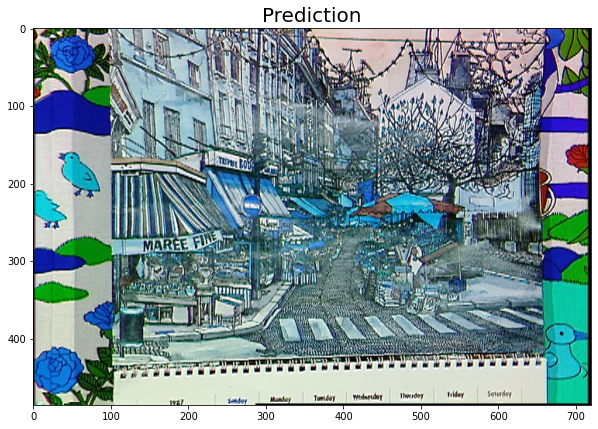

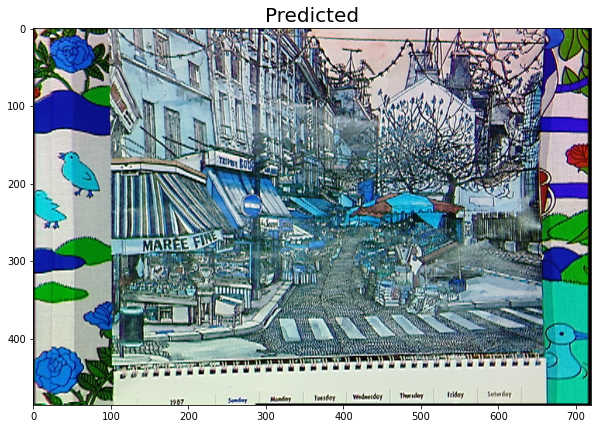

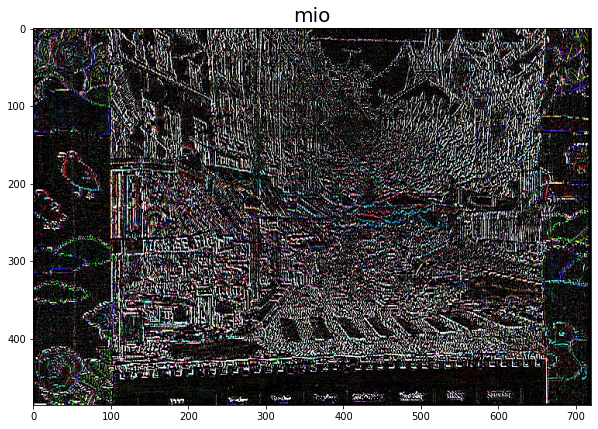

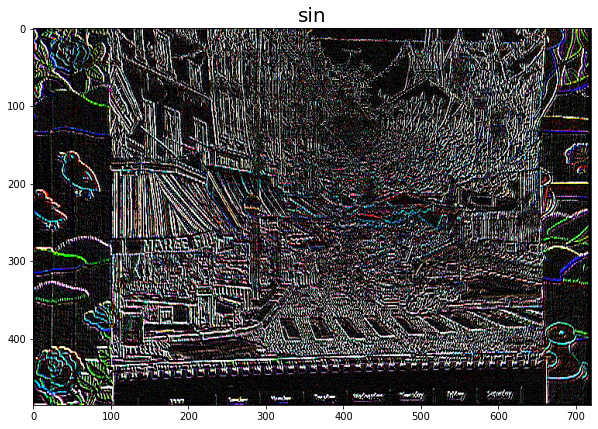

In [10]:
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame((prediction-P)*10, "mio")
show_frame((R-P)*10, "sin")
OF_flow = motion.estimate(P[...,0], R[...,0])
show_frame((motion.make_prediction(R, OF_flow) - P)*10, "OF")

In [11]:
R = YUV.from_RGB(frame.read("../sequences/bus/", 0))
P = YUV.from_RGB(frame.read("../sequences/bus/", 1))

frame.read: ../sequences/bus/000.png (288, 352, 3) uint8 225840 
frame.read: ../sequences/bus/001.png (288, 352, 3) uint8 225003 


In [12]:
flow = full_search_motion_estimation(P[...,0], R[...,0], 32, 17)

frame.read: ../sequences/bus/000.png (288, 352, 3) uint8 225840 
frame.read: ../sequences/bus/001.png (288, 352, 3) uint8 225003 


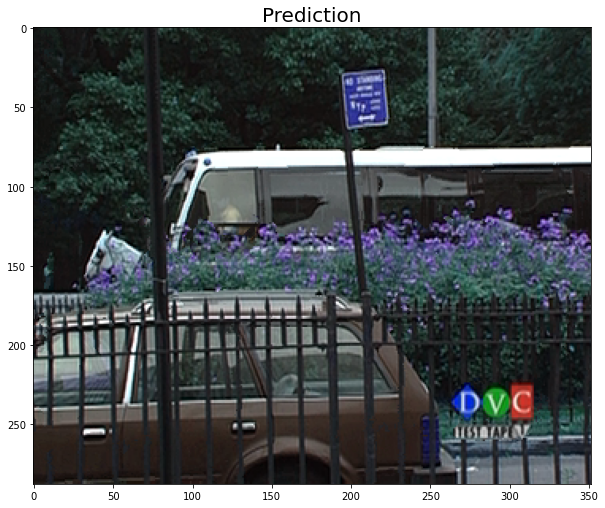

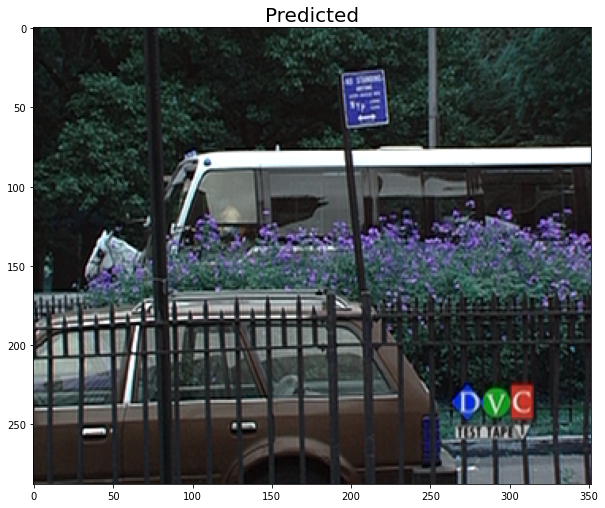

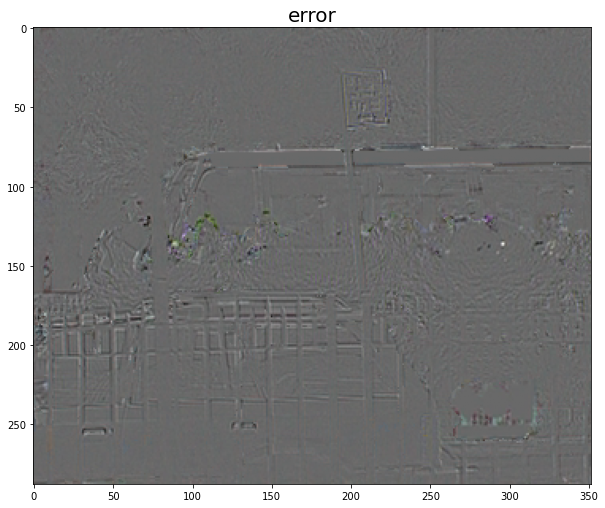

In [13]:
R = frame.read("../sequences/bus/", 0)
P = frame.read("../sequences/bus/", 1)
prediction = motion.make_prediction(R, flow.astype(np.float32))
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame(normalize(prediction-P), "error")

In [14]:
R = YUV.from_RGB(frame.read("../sequences/stockholm/", 0))
P = YUV.from_RGB(frame.read("../sequences/stockholm/", 1))

frame.read: ../sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
frame.read: ../sequences/stockholm/001.png (768, 1280, 3) uint8 1927644 


In [15]:
flow = full_search_motion_estimation(P[...,0], R[...,0], 32, 17)

frame.read: ../sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
frame.read: ../sequences/stockholm/001.png (768, 1280, 3) uint8 1927644 


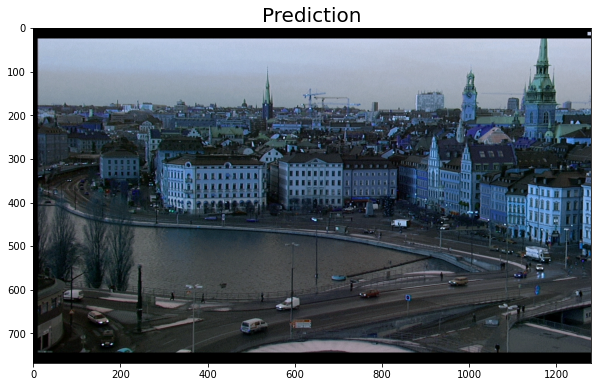

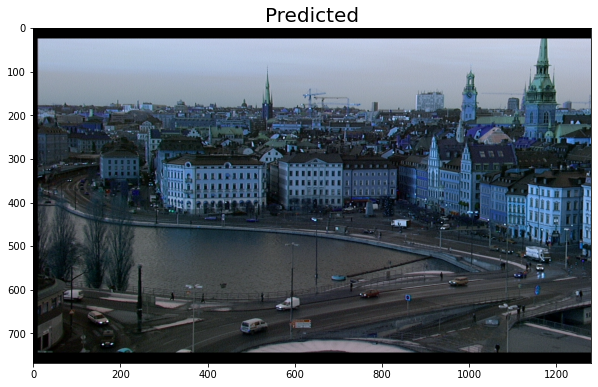

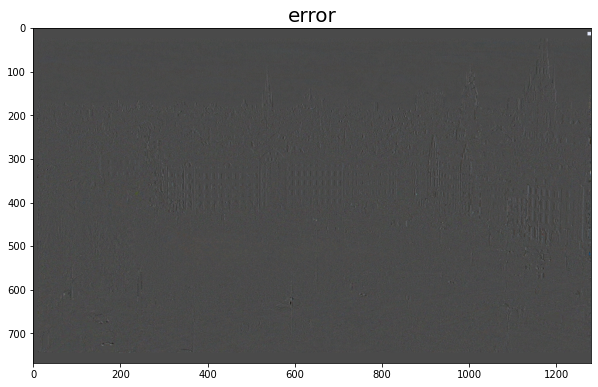

In [16]:
R = frame.read("../sequences/stockholm/", 0)
P = frame.read("../sequences/stockholm/", 1)
prediction = motion.make_prediction(R, flow.astype(np.float32))
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame(normalize(prediction-P), "error")

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/bus/", 0))
P = YUV.from_RGB(frame.read("../sequences/bus/", 1))

In [ ]:
R = cv.pyrUp(R)
P = cv.pyrUp(P)

In [ ]:
print(R.shape, P.shape)

In [ ]:
flow = full_search_motion_estimation(P[...,0], R[...,0], 32, 17)

In [ ]:
print(flow.shape)

In [ ]:
R = frame.read("../sequences/bus/", 0)
R = cv.pyrUp(R)
P = frame.read("../sequences/bus/", 1)
P = cv.pyrUp(P)
prediction = motion.make_prediction(R, flow.astype(np.float32))
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame(normalize(prediction-P), "error")

In [ ]:
R = YUV.from_RGB(frame.read("../sequences/bus/", 0))[...,0]
P = YUV.from_RGB(frame.read("../sequences/bus/", 1))[...,0]
OF_flow = motion.estimate(P.astype(np.float32), R.astype(np.float32),
                          initial_flow=np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32),
                          levels=3, wside=200, iters=1)
R = frame.read("../sequences/bus/", 0)
P = frame.read("../sequences/bus/", 1)
prediction = motion.make_prediction(R, OF_flow.astype(np.float32))
show_frame(prediction, "Prediction")
show_frame(P, "Predicted")
show_frame(normalize(prediction-P), "error")

In [ ]:
        #min_error = np.argmin([min_error, blur_a_error], axis=2)
        show_frame(blur_a_error, f"{y} {x}")
        

In [ ]:
############################3

In [ ]:
D = []
for i in _spiral:
    difference = extended_R[i[0]:R.shape[0]+i[0], i[1]:R.shape[1]+i[1]] - P
    D.append(difference)

In [ ]:
D[1].max()